In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Berger Viscous Equation parameters
c = 1.0    # Wave speed
mu = 0.1   # Viscosity coefficient
lam = 1.0  # Nonlinearity coefficient

# Define the neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential(*[
            nn.Sequential(nn.Linear(layers[i], layers[i+1]), nn.Tanh())
            for i in range(len(layers)-2)
        ] + [nn.Linear(layers[-2], layers[-1])])

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        return self.net(inputs)

# Compute PDE residual using automatic differentiation
def compute_pde_residual(model, x, t):
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    u = model(x, t)  # Predict u(x, t)
    
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    f = u_tt - c**2 * u_xx - mu * u_xx + lam * u * u_xx  # PDE residual
    return f

# Importance sampling: Generate collocation points based on residuals
def generate_collocation_points(model, N_f, L=1.0, T=1.0):
    x_f = torch.rand(N_f, 1, device=device, requires_grad=True) * L  # x in [0, L]
    t_f = torch.rand(N_f, 1, device=device, requires_grad=True) * T  # t in [0, T]
    
    if model is not None:  # Perform importance sampling
        residuals = compute_pde_residual(model, x_f, t_f).detach()
        probabilities = residuals.abs() / torch.sum(residuals.abs())  # Normalize to form a probability distribution
        sampled_indices = torch.multinomial(probabilities.view(-1), N_f, replacement=True)
        x_f, t_f = x_f[sampled_indices], t_f[sampled_indices]
    
    return x_f, t_f

# Define loss function
def loss_function(model, x_f, t_f, x_bc, t_bc, u_bc):
    f_residual = compute_pde_residual(model, x_f, t_f)
    loss_pde = torch.mean(f_residual**2)

    u_pred_bc = model(x_bc, t_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    return loss_pde + loss_bc

# Training loop with dynamic importance sampling
def train(model, optimizer, N_f, x_bc, t_bc, u_bc, epochs=5000, resample_every=500):
    for epoch in range(epochs):
        if epoch % resample_every == 0:
            x_f, t_f = generate_collocation_points(model, N_f)
        
        optimizer.zero_grad()
        loss = loss_function(model, x_f, t_f, x_bc, t_bc, u_bc)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Define PINN model architecture
layers = [2, 50, 50, 50, 1]  # Input (x,t) -> Hidden layers -> Output (u)
model = PINN(layers).to(device)

# Define boundary and initial conditions
N_f = 1000  # Collocation points
L, T = 1.0, 1.0  # Spatial and time limits

x_f, t_f = generate_collocation_points(None, N_f, L, T)  # Initial uniform sampling

# Boundary conditions (u(x, 0) = sin(pi x), u(0, t) = 0, u(L, t) = 0)
N_bc = 100
x_bc = torch.linspace(0, L, N_bc).view(-1, 1).to(device)
t_bc = torch.zeros_like(x_bc).to(device)
u_bc = torch.sin(np.pi * x_bc.cpu()).to(device)  # Initial condition

# Train the model with importance sampling
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, N_f, x_bc, t_bc, u_bc, epochs=10000, resample_every=100)

# Visualize results
x_test = torch.linspace(0, L, 100).view(-1, 1).to(device)
t_test = torch.linspace(0, T, 100).view(-1, 1).to(device)

x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
x_flat, t_flat = x_grid.flatten().view(-1, 1), t_grid.flatten().view(-1, 1)

u_pred = model(x_flat, t_flat).detach().cpu().numpy().reshape(100, 100)



/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.5992962121963501
Epoch 500, Loss: 0.011320780962705612
Epoch 1000, Loss: 0.0012223264202475548
Epoch 1500, Loss: 0.0006964647909626365
Epoch 2000, Loss: 0.0002991192741319537
Epoch 2500, Loss: 0.00017983498401008546
Epoch 3000, Loss: 0.0001834290596889332
Epoch 3500, Loss: 7.26454600226134e-05
Epoch 4000, Loss: 0.0017366184620186687
Epoch 4500, Loss: 0.00012453703675419092
Epoch 5000, Loss: 0.00011623358295764774
Epoch 5500, Loss: 0.0001595417852513492
Epoch 6000, Loss: 2.8628443033085205e-05
Epoch 6500, Loss: 7.228330650832504e-05
Epoch 7000, Loss: 4.042246291646734e-05
Epoch 7500, Loss: 0.0013465964002534747
Epoch 8000, Loss: 4.376715514808893e-05
Epoch 8500, Loss: 6.81006204104051e-05
Epoch 9000, Loss: 3.2045547413872555e-05
Epoch 9500, Loss: 2.3516624423791654e-05


In [5]:
#Loss on general function
x_f, t_f = generate_collocation_points(model, 1000,L,T)
x_bc = torch.linspace(0, L, N_bc).view(-1, 1).to(device)
t_bc = torch.zeros_like(x_bc).to(device)
u_bc = torch.sin(np.pi * x_bc.cpu()).to(device)

loss_function(model, x_f, t_f, x_bc, t_bc, u_bc).item()

2.813389255607035e-05

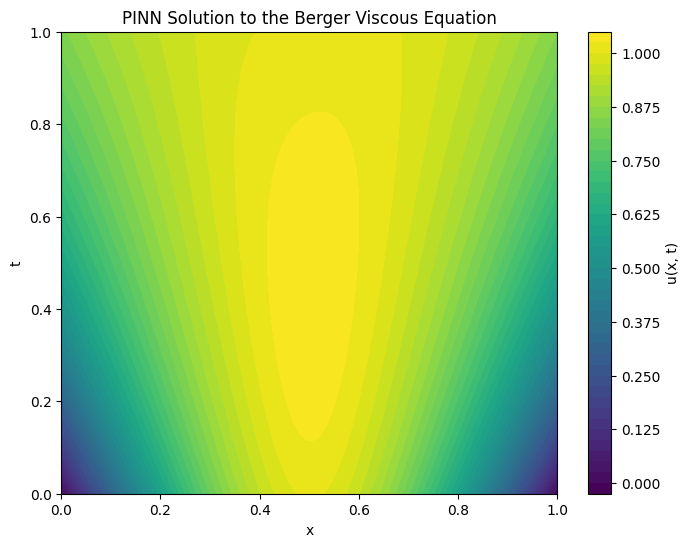

In [23]:
plt.figure(figsize=(8, 6))
plt.contourf(x_grid.cpu().numpy(), t_grid.cpu().numpy(), u_pred, levels=50, cmap='viridis')
plt.colorbar(label="u(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Solution to the Berger Viscous Equation")
plt.show()

In [24]:
x = torch.tensor([[0.5]]).to(device)
t = torch.tensor([[0.5]]).to(device)
u_pred = model(x, t).detach().cpu().numpy()

In [25]:
u_pred

array([[1.0421249]], dtype=float32)

In [32]:
u_pred = model(x_flat, t_flat).detach().cpu().numpy().reshape(100, 100)

In [53]:
u_pred

array([[ 6.0298517e-03,  2.4326656e-02,  4.2341441e-02, ...,
         8.3513224e-01,  8.3859837e-01,  8.4202218e-01],
       [ 3.8651645e-02,  5.6588400e-02,  7.4232362e-02, ...,
         8.4242451e-01,  8.4575391e-01,  8.4904194e-01],
       [ 7.1001999e-02,  8.8564485e-02,  1.0582600e-01, ...,
         8.4955382e-01,  8.5274720e-01,  8.5590070e-01],
       ...,
       [ 6.5848775e-02,  8.4015861e-02,  1.0183948e-01, ...,
         8.5871869e-01,  8.6176991e-01,  8.6477512e-01],
       [ 3.2905430e-02,  5.1493026e-02,  6.9742158e-02, ...,
         8.5086155e-01,  8.5403699e-01,  8.5716528e-01],
       [-3.4364313e-04,  1.8652409e-02,  3.7317023e-02, ...,
         8.4281361e-01,  8.4611458e-01,  8.4936684e-01]], dtype=float32)

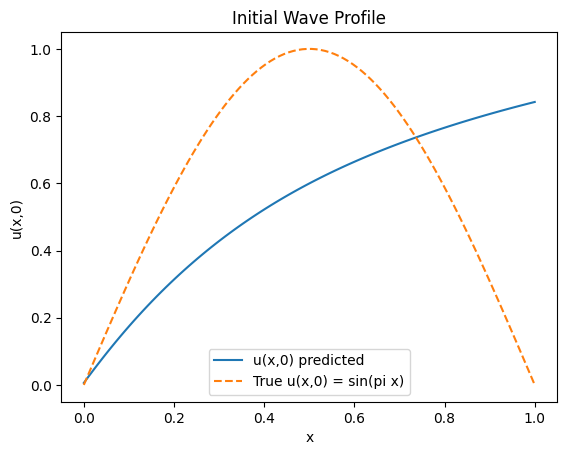

In [36]:
plt.plot(x_test.cpu().numpy(), u_pred[0], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()


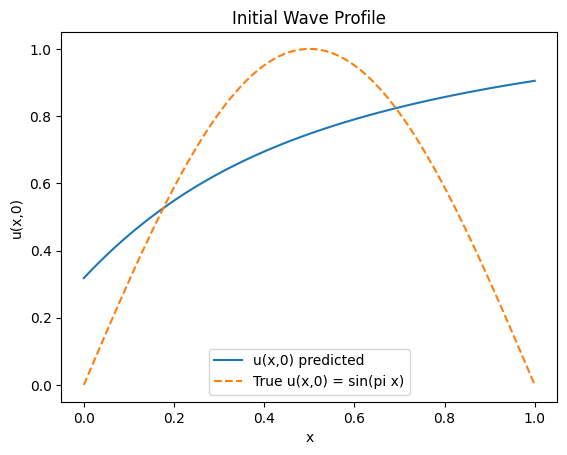

In [38]:
plt.plot(x_test.cpu().numpy(), u_pred[10], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()

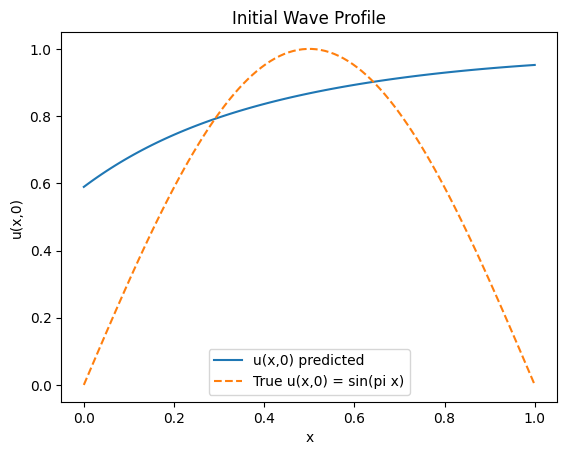

In [40]:
plt.plot(x_test.cpu().numpy(), u_pred[20], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()

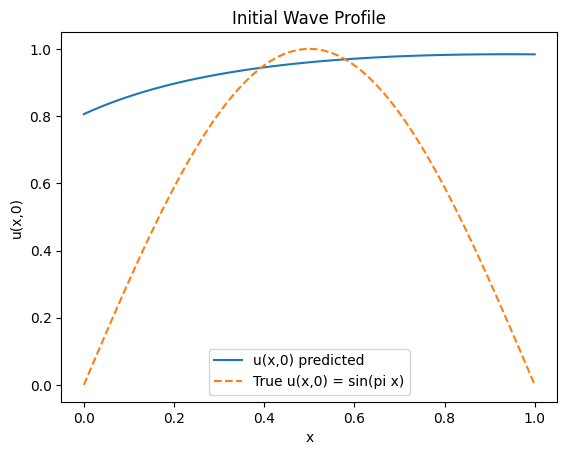

In [43]:
plt.plot(x_test.cpu().numpy(), u_pred[30], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()

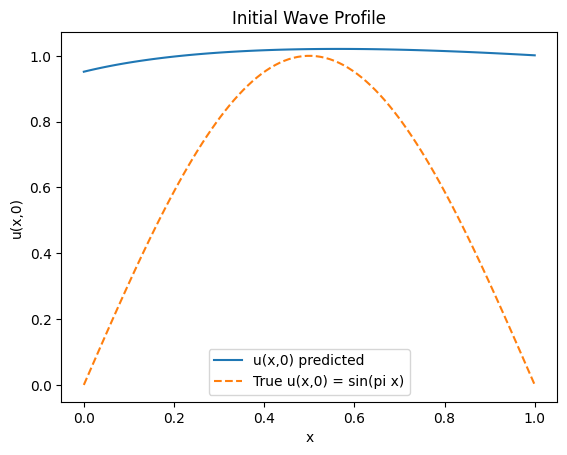

In [45]:
plt.plot(x_test.cpu().numpy(), u_pred[40], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()

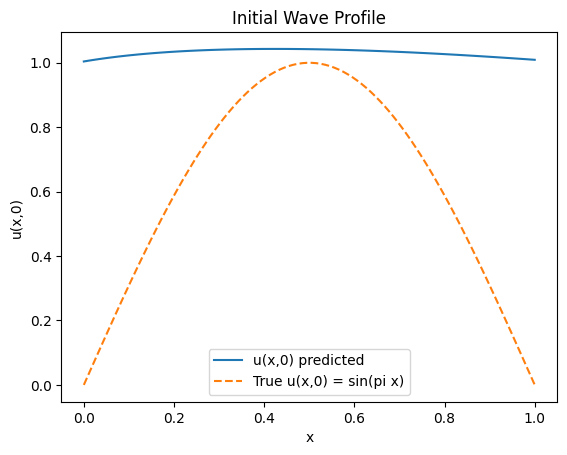

In [47]:
plt.plot(x_test.cpu().numpy(), u_pred[50], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()

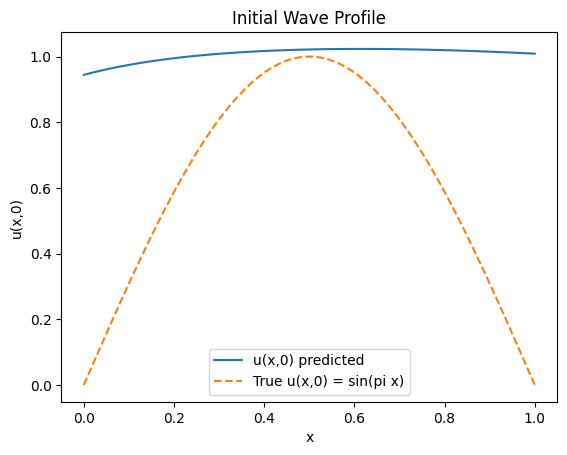

In [49]:
plt.plot(x_test.cpu().numpy(), u_pred[60], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()

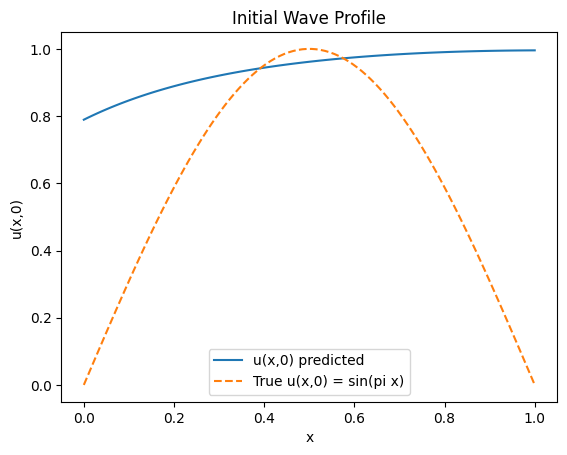

In [51]:
plt.plot(x_test.cpu().numpy(), u_pred[70], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()